<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/benchmarking_inference_speed_gpu_vs_cpu_opencv_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary

In notebook "configure_opencv_with_gpu_on_colab.ipynb" we have seen how to install and configure OpenCV on Colab with GPU support because OpenCV > 4.2. supports NVIDIA GPUs for inference using OpenCV’s dnn module, improving inference speed.

In this notebook, we will benchmark a deep learning model (pre-trained and ready to use using OpenCV) for both CPU and GPU inference speed. More specifically, as an example we will use a pre-trained models for human pose estimation.

References:
*   [Deep Learning based Human Pose Estimation using OpenCV (C++/Python)](https://learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/)
*   [openpose.py](https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.py)
*   [openpose.cpp](https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.cpp)

# Introduction

The pre-trained model used in this notebook is based on the paper [Multi-Person Pose Estimation](https://arxiv.org/pdf/1611.08050.pdf). 

<img align="left" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/icon_book.png" width=50 px>

*Cao, Z., Simon, T., Wei, S. E., & Sheikh, Y. (2017). **Realtime multi-person 2d pose estimation using part affinity fields.** In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 7291-7299).*

The authors of the paper have shared two models. One is trained on the [MPII Human Pose dataset](http://human-pose.mpi-inf.mpg.de/) and the other is trained on the [COCO 2018 Keypoint dataset](https://cocodataset.org/#keypoints-2018):

*  The COCO model produces 18 points
*  MPII model produces 15 points

For simplification, in this notebook, we are going to use the MPII one. MPII output format is as follows: 

```
Head – 0
Neck – 1
Right Shoulder – 2 
Right Elbow – 3
Right Wrist – 4
Left Shoulder – 5
Left Elbow – 6
Left Wrist – 7
Right Hip – 8
Right Knee – 9
Right Ankle – 10
Left Hip – 11
Left Knee – 12
Left Ankle – 13
Chest – 14
Background – 15
```

As a final note in the introduction, we can make use of the following command to see the characteristics of the GPU we are using in Colab.

In [21]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ec920886-668d-ad63-e0df-cc77e5673b16)


# Load and test the inference time with no GPU support

First step is to download models trained on Caffe Deep Learning Framework. Two files are needed:
*   **.prototxt** file, which specifies the architecture of the neural network.
*   **.caffemodel** file, which stores the weights of the trained model.

In the file [openpose.cpp](https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.cpp) included in the OpenCV repository, you can see the links to download the aforementioned two files for both the COCO model and the MPII model.

In [22]:
# here you can see the links: https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.cpp
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/openpose_pose_mpi_faster_4_stages.prototxt
!wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel

--2021-03-30 13:16:45--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/openpose_pose_mpi_faster_4_stages.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32813 (32K) [text/plain]
Saving to: ‘openpose_pose_mpi_faster_4_stages.prototxt.1’

openpose_pose_mpi_f 100%[===================>]  32.04K  --.-KB/s    in 0.002s  

2021-03-30 13:16:46 (19.7 MB/s) - ‘openpose_pose_mpi_faster_4_stages.prototxt.1’ saved [32813/32813]

--2021-03-30 13:16:46--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
H

In [23]:
# Set both proto file and weights with the names of the downloaded files:
proto_file = "openpose_pose_mpi_faster_4_stages.prototxt"
weights_file = "pose_iter_160000.caffemodel"

At this point, we can read the network into memory. Note the two commented lines (OpenCV version < 4.2):

In [24]:
import cv2

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [25]:
NPOINTS = 15
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

We download a sample image and rename it to 'messi.jpg':

In [26]:
!wget "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg" -O messi.jpg

--2021-03-30 13:18:53--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72937 (71K) [image/jpeg]
Saving to: ‘messi.jpg’

messi.jpg           100%[===================>]  71.23K  --.-KB/s    in 0.008s  

2021-03-30 13:18:53 (8.96 MB/s) - ‘messi.jpg’ saved [72937/72937]



We can show the image we have just downloaded.

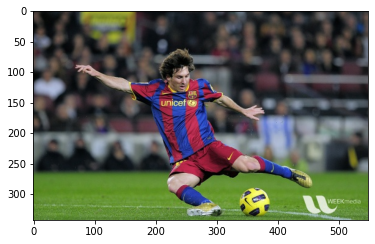

In [27]:
from matplotlib import pyplot as plt

frame = cv2.imread('./messi.jpg')

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()


At this point, we can start coding.

In [29]:
import numpy as np

frame_copy = np.copy(frame)
frame_prob_map = np.copy(frame)

frame_width = frame.shape[1]
frame_height = frame.shape[0]

threshold = 0.1

The input `frame` that we read using OpenCV should be converted to a blob so that it can be fed to the network. This is done using the `cv2.dnn.blobFromImage()` function,  which converts the image from OpenCV format to Caffe blob format with the following parameters:
- normalize the pixel values in `(0,1)` range
- specify the dimensions of the image
- the mean value to be subtracted, which is `(0,0,0)`.
- no need to swap the `R` and `B` channels (since both OpenCV and Caffe use BGR format).

To know more about `cv2.dnn.blobFromImage()`, `cv2.dnn.blobFromImages()`, `cv2.dnn.imagesFromBlob()` you can check [this collection of Python scripts](https://github.com/PacktPublishing/Mastering-OpenCV-4-with-Python/tree/master/Chapter12/01-chapter-content/opencv/blob_from_images).

Once the blob is passed to the model using `net.setInput(inpBlob)`, the predictions can be obtained calling `net.forward()`, which performs a forward pass through the network, obtaining the predictions.


In [34]:
import time
t = time.time()

# input image dimensions for the network
in_width = 368
in_height = 368
blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (in_width, in_height), (0, 0, 0), swapRB=False, crop=False)

net.setInput(blob)
output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

# Get inference time using net.getPerfProfile():
t, _ = net.getPerfProfile()
print("Inference time : {:.3f}".format(t / cv2.getTickFrequency()))

time taken by network : 4.103
Inference time : 4.097


Show the shape of the `output`:

In [35]:
print(output.shape)

(1, 16, 46, 46)


The output is a 4D matrix:
- first dimension is the image ID (more than one images can be passed to the network)
- second dimension indicates the index of the key point
- third and fourth dimensions are the height and with of the output map (confidence map)


At this point, we can show the results using `output` result.

In [36]:
ID = output.shape[0]
H = output.shape[2]
W = output.shape[3]

print("ID: {}".format(ID))
print("H: {}".format(H))
print("W: {}".format(W))

# Empty list to store the detected keypoints
points = []

# Empty list to store the detected probability maps for the detected keypoints:
prob_maps = []

# Iterate over all body's part
# We don't want background (Background – 15)
for i in range(NPOINTS):    
    # confidence map of corresponding body's part.
    prob_map = output[0, i, :, :]
    # print("prob_map shape {}: {}".format(i, prob_map.shape))

    # Save the prability maps (scaled to the size of the source frame):
    prob_maps.append(cv2.resize(prob_map, (frame_width, frame_height)))

    # Find global maxima of the prob_map.
    # cv2.minMaxLoc() returns: minVal, maxVal, minLoc and maxLoc
    # We want maxVal (save it as 'prob') and maxLoc (save it as 'point')
    minVal, prob, minLoc, point = cv2.minMaxLoc(prob_map)
    
    # Scale the point to fit on the original image:
    x = (frame_width * point[0]) / W
    y = (frame_height * point[1]) / H

    if prob > threshold : 
        cv2.circle(frame_copy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frame_copy, "{}".format(i), (int(x), int(y)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else:
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

ID: 1
H: 46
W: 46


We can show the probability maps. For example, this is the probability map of the head.

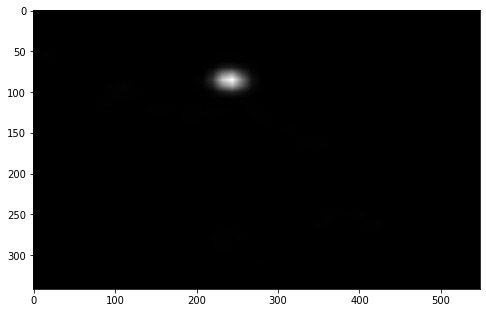

In [38]:
import matplotlib.pyplot as plt

HEAD_INDEX = 0
prob_map_head = prob_maps[HEAD_INDEX]

plt.figure(figsize=(8,10))
plt.imshow(prob_map_head, cmap=plt.get_cmap('gray'))

Hence, we can show the probability map over the source image including transparency using `alpha` argument.

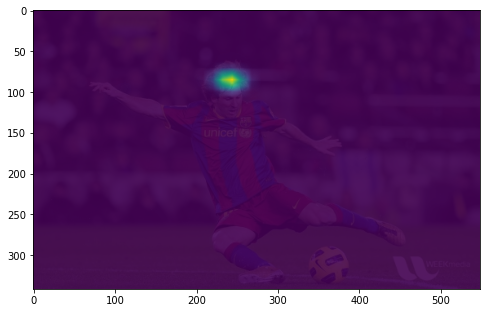

In [39]:
import matplotlib.pyplot as plt

HEAD_INDEX = 0
prob_map_head = prob_maps[HEAD_INDEX]

plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(frame_prob_map, cv2.COLOR_BGR2RGB))
plt.imshow(prob_map_head, alpha=0.9)

If we want to show the probability map of the left wrist:

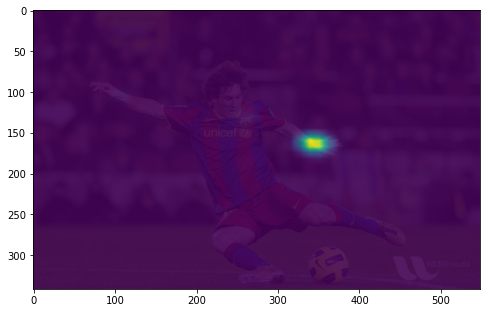

In [40]:
import matplotlib.pyplot as plt

LEFT_WRIST_INDEX = 7
prob_map_left_wrist = prob_maps[LEFT_WRIST_INDEX]

plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(frame_prob_map, cv2.COLOR_BGR2RGB))
plt.imshow(prob_map_left_wrist, alpha=0.9)

We can show the image `frame` to show the skeleton:

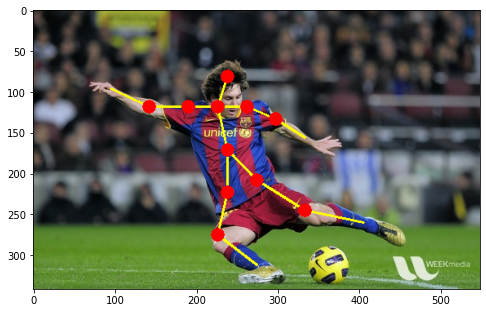

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

And finally, we can show `frame_copy` to show the key points.

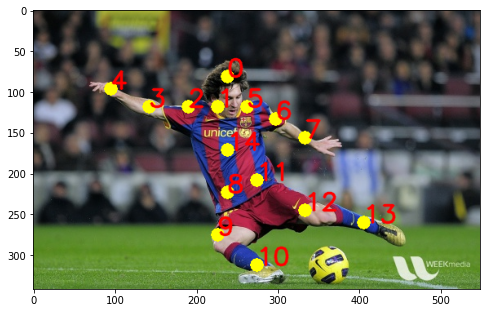

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.show()

# Install and test OpenCV with GPU support

The first step is to install OpenCV (> 4.2) from source code with GPU support because OpenCV’s dnn module requires you to compile OpenCV from source code and you cannot "pip install" OpenCV with GPU support.
See [this notebook](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/configure_opencv_with_gpu_on_colab.ipynb) for more information about this.


In [43]:
# Download and install OpenCV 4.5.1 library compiled with GPU support
# See notebook 'configure_opencv_with_gpu_on_colab.ipynb' for more info
!gdown --id 1-Ze3zkdzA_kDsakY_hGAZRh3aK3p5lHk

Downloading...
From: https://drive.google.com/uc?id=1-Ze3zkdzA_kDsakY_hGAZRh3aK3p5lHk
To: /content/cv2.cpython-36m-x86_64-linux-gnu.so
984MB [00:04, 235MB/s]


We have also to rename the file to cv2.so (seen here: https://gist.github.com/Mahedi-61/804a663b449e4cdb31b5fea96bb9d561)

In [44]:
!mv cv2.cpython-36m-x86_64-linux-gnu.so cv2.so

Output the version of OpenCV. If installed version is not 4.5.1, we have to restart the runtime to refresh the installed version of OpenCV.

In [46]:
import cv2

print("OpenCV version: '{}'".format(cv2.__version__))

OpenCV version: '4.1.2'


So restart the runtime if needed.

In [ ]:
# Restart the runtime:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

Let's check all the properties from the installation.

In [1]:
import cv2
print("Just a reminder from our previous notebook 'configure_opencv_with_gpu_on_colab.ipynb'")
print("You need OpenCV 4.2 or above to use DNN_BACKEND_CUDA & DNN_TARGET_CUDA")
print("Lets check it")
print("Current OpenCV installation: '{}'".format(cv2.__version__))
try:
  print("cv2.dnn.DNN_BACKEND_CUDA: '{}'".format(cv2.dnn.DNN_BACKEND_CUDA))
  print("cv2.dnn.DNN_TARGET_CUDA: '{}'".format(cv2.dnn.DNN_TARGET_CUDA))
except AttributeError: 
  print("CUDA backend will not be used in this notebook")

Just a reminder from our previous notebook 'configure_opencv_with_gpu_on_colab.ipynb'
You need OpenCV 4.2 or above to use DNN_BACKEND_CUDA & DNN_TARGET_CUDA
Lets check it
Current OpenCV installation: '4.5.1-dev'
cv2.dnn.DNN_BACKEND_CUDA: '5'
cv2.dnn.DNN_TARGET_CUDA: '6'


Finally, let's see if there is NVIDA, CUDA or CUDNN information included in the build information using `cv2.getBuildInformation()`:

In [2]:
import cv2
import re

cv_info = [re.sub('\s+', ' ', ci.strip()) for ci in cv2.getBuildInformation().strip().split('\n') 
               if len(ci) > 0 and re.search(r'(nvidia*:?)|(cuda*:)|(cudnn*:)', ci.lower()) is not None]
print(cv_info)

['NVIDIA CUDA: YES (ver 10.1, CUFFT CUBLAS)', 'NVIDIA GPU arch: 30 35 37 50 52 60 61 70 75', 'NVIDIA PTX archs:', 'cuDNN: YES (ver 7.6.5)']


At this point, with OpenCV correctly installed with GPU support, we compare the execution time (for inference) with and without setting the following two lines of code:

```
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
```

In this first case, the two aforementioned lines are commented.



In [4]:
import cv2

# Set both proto file and weights with the names of the downloaded files:
proto_file = "openpose_pose_mpi_faster_4_stages.prototxt"
weights_file = "pose_iter_160000.caffemodel"

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

frame = cv2.imread('./messi.jpg')

import time
t = time.time()
# input image dimensions for the network
in_width = 368
in_height = 368
blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (in_width, in_height), (0, 0, 0), swapRB=False, crop=False)

net.setInput(blob)
output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

# Get inference time using net.getPerfProfile():
t, _ = net.getPerfProfile()
print("Inference time : {:.3f}".format(t / cv2.getTickFrequency()))

time taken by network : 2.565
Inference time : 2.556


In [7]:
import cv2

# Set both proto file and weights with the names of the downloaded files:
proto_file = "openpose_pose_mpi_faster_4_stages.prototxt"
weights_file = "pose_iter_160000.caffemodel"

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

frame = cv2.imread('./messi.jpg')

import time
t = time.time()
# input image dimensions for the network
in_width = 368
in_height = 368
blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (in_width, in_height), (0, 0, 0), swapRB=False, crop=False)

net.setInput(blob)
output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

# Get inference time using net.getPerfProfile():
t, _ = net.getPerfProfile()
print("Inference time : {:.3f}".format(t / cv2.getTickFrequency()))

time taken by network : 0.131
Inference time : 0.002


Finally, we present the results in a "friendly way".

In [8]:
# importing the modules 
from IPython.display import display, HTML 
import pandas as pd 
  
# creating a DataFrame 
dict = {'OpenCV version' : ['OpenCV 4.1.2','4.5.1-dev','4.5.1-dev'], 
        'GPU Support' : ['NO', 'YES', 'YES'], 
        'DNN_BACKEND_CUDA and DNN_TARGET_CUDA' : ['NO', 'NO', 'YES'],
        'Inference time': ['4.203','2.556','0.130']} 
df = pd.DataFrame(dict) 

# displaying the DataFrame (without showing the row indices)
HTML(df.to_html(index=False))

OpenCV version,GPU Support,DNN_BACKEND_CUDA and DNN_TARGET_CUDA,Inference time
OpenCV 4.1.2,NO,NO,4.203
4.5.1-dev,YES,NO,2.556
4.5.1-dev,YES,YES,0.130


# Conclusions

In this notebook, and as an example, we benchmarked a deep learning model (pre-trained and ready to use using OpenCV) for both CPU and GPU inference speed. This example is used for human pose estimation (for a single person). For multi-person pose estimation in OpenCV, [you can check the following post](https://learnopencv.com/multi-person-pose-estimation-in-opencv-using-openpose/).

Note that in notebook "configure_opencv_with_gpu_on_colab.ipynb" we have seen how to install and configure OpenCV on Colab with GPU support because OpenCV > 4.2. supports NVIDIA GPUs for inference using OpenCV’s dnn module, improving inference speed.
